In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import pygrib
from os.path import exists, join
from glob import glob
import os
import cartopy.crs as ccrs
import cartopy.feature as cfs
from scipy.ndimage import maximum_filter
from skimage.measure import block_reduce
from hagelslag.evaluation.ProbabilityMetrics import DistributedROC
from hagelslag.evaluation.MetricPlotter import performance_diagram
from matplotlib.colors import LogNorm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import partial_dependence
%matplotlib inline

In [7]:
!ncdump -h /glade/p/cisl/aiml/hail/SPC_Outlooks/210507_25_spc_outlook.nc

netcdf \210507_25_spc_outlook {
dimensions:
	lon = 1059 ;
	lat = 1799 ;
variables:
	double lon(lon) ;
		lon:_FillValue = NaN ;
	double lat(lat) ;
		lat:_FillValue = NaN ;
	double SPC\ Hail\ Probs(lon, lat) ;
		SPC\ Hail\ Probs:_FillValue = NaN ;
}


In [2]:
ls /glade/p/cisl/aiml/hail/HREF/*2021050300.grib2

/glade/p/cisl/aiml/hail/HREF/HREF_4LFTX_2021050300.grib2
/glade/p/cisl/aiml/hail/HREF/HREF_CAPESHEAR_2021050300.grib2
/glade/p/cisl/aiml/hail/HREF/HREF_HLCY3_0_2021050300.grib2
/glade/p/cisl/aiml/hail/HREF/HREF_LR75_2021050300.grib2
/glade/p/cisl/aiml/hail/HREF/HREF_LR850_500_2021050300.grib2
/glade/p/cisl/aiml/hail/HREF/HREF_magSHEAR10_500mb_2021050300.grib2
/glade/p/cisl/aiml/hail/HREF/HREF_MAXUVV_2021050300.grib2
/glade/p/cisl/aiml/hail/HREF/HREF_maxWind10m_mag_2021050300.grib2
/glade/p/cisl/aiml/hail/HREF/HREF_MLCAPE_2021050300.grib2
/glade/p/cisl/aiml/hail/HREF/HREF_MXUPHL5_2_2021050300.grib2
/glade/p/cisl/aiml/hail/HREF/HREF_SCP_2021050300.grib2
/glade/p/cisl/aiml/hail/HREF/HREF_SHIP_2021050300.grib2
/glade/p/cisl/aiml/hail/HREF/HREF_TMP500_2021050300.grib2
/glade/p/cisl/aiml/hail/HREF/HREF_TMP850_2021050300.grib2
/glade/p/cisl/aiml/hail/HREF/HREF_UGRD10m_2021050300.grib2
/glade/p/cisl/aiml/hail/HREF/HREF_VGRD10m_2021050300.grib2


In [2]:
var_files = glob("/glade/p/cisl/aiml/hail/HREF/*2021050300.grib2")
href_vars = [vf.split("/")[-1][5:-17] for vf in var_files]
href_vars

['TMP500',
 'magSHEAR10_500mb',
 'MLCAPE',
 'VGRD10m',
 'MXUPHL5_2',
 'LR75',
 '4LFTX',
 'HLCY3_0',
 'SHIP',
 'SCP',
 'LR850_500',
 'maxWind10m_mag',
 'UGRD10m',
 'TMP850',
 'CAPESHEAR',
 'MAXUVV']

In [10]:
data_obj

1:Pressure reduced to MSL:Pa (instant):lambert:meanSea:level 0:fcst time 16 hrs:from 201902150000

Path to files on casper: /glade/p/cisl/aiml/hail

In [2]:
data_path = "/glade/p/cisl/aiml/hail/"

def load_burke_dl(date, path=data_path):
    date_str = date.strftime("%y%m%d")
    out_date = date.strftime("%Y%m%d")
    filename = f"HREFv2_Hail_DL_NMEP_smoothed_25mm_{date_str}_Hours_12-36.grib2"
    full_file = join(path, "burke_dl", filename)
    out_dict = {}
    if not exists(full_file):
        print(full_file + " not found")
        out_dict[out_date] = np.zeros((1059, 1799), dtype=np.float32)
    else:
        with pygrib.open(full_file) as grib_obj:
            data_obj = grib_obj.read()[0]
            out_dict[out_date], out_dict["lat"], out_dict["lon"] = data_obj.data()
            for k, v in out_dict.items():
                out_dict[k] = v.astype(np.float32)
    return out_dict

def load_burke_rf(date, path=data_path):
    date_str = date.strftime("%y%m%d")
    out_date = date.strftime("%Y%m%d")
    filename = f"HREFv2_Random-Forest_Hail_mesh_Cali_NMEP_25mm_{date_str}_Hours_12-36.grib2"
    full_file = join(path, "burke_rf", filename)
    out_dict = {}
    if not exists(full_file):
        out_dict[out_date] = np.zeros((1059, 1799), dtype=np.float32)
    else:
        with pygrib.open(full_file) as grib_obj:
            data_obj = grib_obj.read()[0]
            out_dict[out_date], out_dict["lat"], out_dict["lon"] = data_obj.data()
            for k, v in out_dict.items():
                out_dict[k] = v.astype(np.float32)
    return out_dict

def load_href(date, variable, path=data_path):
    date_str = date.strftime("%Y%m%d%H")
    out_date = date.strftime("%Y%m%d")
    out_dict = {}
    filename_template = f"HREF_{variable}_{date_str}.grib2"
    full_file = join(path, "HREF", filename_template)
    with pygrib.open(full_file) as grib_obj:
        data_obj = grib_obj.read()[0]
        out_dict[out_date], _, _ = data_obj.data()
        out_dict[out_date] = out_dict[out_date].astype(np.float32)
    return out_dict

def load_loken_rf(date, path=data_path):
    date_str = date.strftime("%Y%m%d")
    out_date = date.strftime("%Y%m%d")
    filename = f"{date_str}_HREF_probs_any_hail.grib2"
    full_file = join(path, "loken_rf_extended", filename)
    out_dict = {}
    if not exists(full_file):
        print(full_file + " missing")
        out_dict[out_date] = np.zeros((1059, 1799), dtype=np.float32)
    else:
        with pygrib.open(full_file) as grib_obj:
            data_obj = grib_obj.read()[0]
            out_dict[out_date], out_dict["lat"], out_dict["lon"] = data_obj.data()
            out_dict[out_date][out_dict[out_date] < 0] = 0
            for k, v in out_dict.items():
                out_dict[k] = v.astype(np.float32)
                
    return out_dict

def load_spc_con_probs(date, hour=12, path=data_path):
    date_str = date.strftime("%Y%m%d")
    out_date = date.strftime("%Y%m%d")
    filename = f"hail_day1_conProbs_{date_str}{hour:d}00_href.grib2"
    full_file = join(path, "SPC_conProbs", filename)
    out_dict = {}
    if not exists(full_file):
        print(full_file + " missing")
        out_dict[out_date] = np.zeros((1059, 1799), dtype=np.float32)
    else:
        with pygrib.open(full_file) as grib_obj:
            data_obj = grib_obj.read()[0]
            out_dict[out_date], out_dict["lat"], out_dict["lon"] = data_obj.data()
            out_dict[out_date][out_dict[out_date] < 0] = 0
            for k, v in out_dict.items():
                out_dict[k] = v.astype(np.float32)
                
    return out_dict

def load_spc_06_probs(date, path=data_path):
    return load_spc_con_probs(date, hour=12, path=data_path)

def load_spc_13_probs(date, path=data_path):
    return load_spc_con_probs(date, hour=13, path=data_path)

def load_spc_outlook_nc(date, path=data_path):
    date_str = date.strftime("%y%m%d")
    out_date = date.strftime("%Y%m%d")
    filename = f"{date_str}_25_spc_outlook.nc"
    full_file = join(path, "SPC_Outlooks", filename)
    out_dict = {}
    if not exists(full_file):
        print(full_file + " missing")
        out_dict[out_date] = np.zeros((1059, 1799), dtype=np.float32)
    else:
        ds = xr.open_dataset(full_file)
        out_dict[out_date] = ds["SPC Hail Probs"].values.astype(np.float32)
        out_dict["lon"] = ds["lon"].values.astype(np.float32)
        out_dict["lat"] = ds["lon"].values.astype(np.float32)
        ds.close()
    return out_dict

def load_lsr_grid(date, path=data_path):
    date_str = date.strftime("%y%m%d")
    out_date = date.strftime("%Y%m%d")
    filename = f"{date_str}_25_lsr_mask.nc"
    full_file = join(path, "LSR", filename)
    out_dict = {}
    if not exists(full_file):
        print(full_file + " missing")
        out_dict[out_date] = np.zeros((1059, 1799), dtype=np.float32)
    else:
        ds = xr.open_dataset(full_file)
        out_dict[out_date] = ds["24_Hour_All_12z_12z"].values.astype(np.float32)
        out_dict["lon"] = ds["Longitude"].values.astype(np.float32)
        out_dict["lat"] = ds["Latitude"].values.astype(np.float32)
        ds.close()
    return out_dict

def attributes_diagram(rel_objs, obj_labels, colors, markers, filename, figsize=(8, 8), xlabel="Forecast Probability",
                       ylabel="Observed Relative Frequency", ticks=np.arange(0, 1.05, 0.05), dpi=300,
                       title="Attributes Diagram", legend_params=None, inset_params=None,
                       inset_position=(0.12, 0.72, 0.25, 0.25), bootstrap_sets=None, ci=(2.5, 97.5), title_fontsize=16,
                      label_fontsize=14):
    """
    Plot reliability curves against a 1:1 diagonal to determine if probability forecasts are consistent with their
    observed relative frequency. Also adds gray areas to show where the climatological probabilities lie and what
    areas result in a positive Brier Skill Score.
    Args:
        rel_objs (list): List of DistributedReliability objects.
        obj_labels (list): List of labels describing the forecast model associated with each curve.
        colors (list): List of colors for each line
        markers (list): List of line markers
        filename (str): Where to save the figure.
        figsize (tuple): (Width, height) of the figure in inches.
        xlabel (str): X-axis label
        ylabel (str): Y-axis label
        ticks (`numpy.ndarray`): Tick value labels for the x and y axes.
        dpi (int): resolution of the saved figure in dots per inch.
        title (str): Title of figure
        legend_params (dict): Keyword arguments for the plot legend.
        inset_params (dict): Keyword arguments for the inset axis.
        inset_position (tuple): Position of the inset axis in normalized axes coordinates (left, bottom, width, height)
        bootstrap_sets (list): A list of arrays of bootstrapped DistributedROC objects. If not None,
            confidence regions will be plotted.
        ci (tuple): tuple of bootstrap confidence interval percentiles
    """
    if legend_params is None:
        legend_params = dict(loc=4, fontsize=10, framealpha=1, frameon=True)
    if inset_params is None:
        inset_params = dict(width="25%", height="25%", loc=2, axes_kwargs=dict(facecolor='white'))
    fig, ax = plt.subplots(figsize=figsize)
    plt.plot(ticks, ticks, "k--")
    inset_hist = inset_axes(ax, **inset_params)
    ip = InsetPosition(ax, inset_position)
    inset_hist.set_axes_locator(ip)
    climo = rel_objs[0].climatology()
    no_skill = 0.5 * ticks + 0.5 * climo
    skill_x = [climo, climo, 1, 1, climo, climo, 0, 0, climo]
    skill_y = [climo, 1, 1, no_skill[-1], climo, 0, 0, no_skill[0], climo]
    f = ax.fill(skill_x, skill_y, "0.8")
    f[0].set_zorder(1)
    ax.plot(ticks, np.ones(ticks.shape) * climo, "k--")
    if bootstrap_sets is not None:
        for b, b_set in enumerate(bootstrap_sets):
            brel_curves = np.vstack([b_rel.reliability_curve()["Positive_Relative_Freq"].values for b_rel in b_set])
            rel_range = np.nanpercentile(brel_curves, ci, axis=0)
            fb = ax.fill_between(b_set[0].thresholds[:-1], rel_range[1], rel_range[0], alpha=0.5, color=colors[b])
            fb.set_zorder(2)
    for r, rel_obj in enumerate(rel_objs):
        rel_curve = rel_obj.reliability_curve()
        ax.plot(rel_curve["Bin_Start"], rel_curve["Positive_Relative_Freq"], color=colors[r],
                marker=markers[r], label=obj_labels[r])
        inset_hist.semilogy(rel_curve["Bin_Start"] * 100, rel_obj.frequencies["Total_Freq"][:-1], color=colors[r],
                            marker=markers[r])
    inset_hist.set_xlabel("Forecast Probability")
    inset_hist.set_ylabel("Frequency")
    ax.annotate("No Skill", (0.6, no_skill[12]), rotation=22.5)
    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)
    ax.set_xticks(ticks)
    ax.set_xticklabels((ticks * 100).astype(int))
    ax.set_yticks(ticks)
    ax.set_yticklabels((ticks * 100).astype(int))
    ax.legend(**legend_params)
    ax.set_title(title, fontsize=title_fontsize)
    plt.savefig(filename, dpi=dpi, bbox_inches="tight", facecolor="w")
    plt.close()

def performance_diagram(roc_objs, obj_labels, colors, markers, filename, figsize=(8, 8),
                        xlabel="Success Ratio (1-FAR)",
                        ylabel="Probability of Detection", ticks=np.arange(0, 1.1, 0.1),
                        dpi=300, csi_cmap="Blues",
                        csi_label="Critical Success Index", title="Performance Diagram",
                        legend_params=None, bootstrap_sets=None, ci=(2.5, 97.5), label_fontsize=14,
                        title_fontsize=16, tick_fontsize=12):
    """
    Draws a performance diagram from a set of DistributedROC objects.
    A performance diagram is a variation on the ROC curve in which the Probability of False Detection on the
    x-axis has been replaced with the Success Ratio (1-False Alarm Ratio or Precision). The diagram also shows
    the Critical Success Index (CSI or Threat Score) as a series of curved contours, and the frequency bias as
    angled diagonal lines. Points along the 1:1 diagonal are unbiased, and better performing models should appear
    in the upper right corner. The performance diagram is particularly useful for displaying verification for
    severe weather warnings as it displays all three commonly used statistics (POD, FAR, and CSI) simultaneously
    on the same chart.
    Args:
        roc_objs (list): DistributedROC objects being plotted.
        obj_labels: list or array of labels describing each DistributedROC object.
        obj_labels (list): Label describing the forecast associated with a DistributedROC object.
        colors (list): List of matplotlib-readable colors (names or hex-values) for each curve.
        markers (list): Matplotlib marker (e.g. *, o, v, etc.) for each curve.
        filename (str): Name of figure file being saved.
        figsize (tuple): (Width, height) of the figure in inches.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): The title of the figure.
        ticks (numpy.ndarray): Values shown on the x and y axes.
        dpi (int): Figure resolution in dots per inch.
        csi_cmap (str): Matplotlib colormap used to fill CSI contours.
        csi_label (str): Label for CSI colormap.
        legend_params (None or dict): Keyword arguments for the formatting of the figure legend.
        bootstrap_sets (list): A list of arrays of bootstrapped DistributedROC objects. If not None,
            confidence regions will be plotted.
        ci (tuple): tuple of bootstrap confidence interval percentiles.
        label_fontsize (int): Font size of the x and y axis labels.
        title_fontsize (int): Font size of the title.
        tick_fontsize (int): Font size of the x and y tick labels.
    Examples:
        >>> from hagelslag.evaluation.ProbabilityMetrics import DistributedROC
        >>> import numpy as np
        >>> forecasts = np.random.random(1000)
        >>> obs = np.random.random_integers(0, 1, 1000)
        >>> roc = DistributedROC()
        >>> roc.update(forecasts, obs)
        >>> performance_diagram([roc], ["Random"], ["orange"], ["o"], "random_performance.png")
    """
    if legend_params is None:
        legend_params = dict(loc=4, fontsize=10, framealpha=1, frameon=True)
    plt.figure(figsize=figsize)
    grid_ticks = np.arange(0, 1.01, 0.01)
    sr_g, pod_g = np.meshgrid(grid_ticks, grid_ticks)
    bias = pod_g / sr_g
    csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)
    csi_contour = plt.contourf(sr_g, pod_g, csi, np.arange(0.1, 1.1, 0.1), extend="max", cmap=csi_cmap)
    b_contour = plt.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors="k", linestyles="dashed")
    plt.clabel(b_contour, fmt="%1.1f", manual=[(0.2, 0.9), (0.4, 0.9), (0.6, 0.9), (0.7, 0.7)])
    if bootstrap_sets is not None:
        for b, b_set in enumerate(bootstrap_sets):
            perf_curves = np.dstack([b_roc.performance_curve().values for b_roc in b_set])
            pod_range = np.nanpercentile(perf_curves[:, 0], ci, axis=1)
            sr_range = np.nanpercentile(1 - perf_curves[:, 1], ci, axis=1)
            pod_poly = np.concatenate((pod_range[1], pod_range[0, ::-1]))
            sr_poly = np.concatenate((sr_range[1], sr_range[0, ::-1]))
            pod_poly[np.isnan(pod_poly)] = 0
            sr_poly[np.isnan(sr_poly)] = 1
            plt.fill(sr_poly, pod_poly, alpha=0.5, color=colors[b])
    for r, roc_obj in enumerate(roc_objs):
        perf_data = roc_obj.performance_curve()
        plt.plot(1 - perf_data["FAR"], perf_data["POD"], marker=markers[r], color=colors[r], label=obj_labels[r])
        for t, threshold in enumerate(perf_data["Thresholds"]):
            if ~np.isnan(perf_data.loc[t, "FAR"]) and ~np.isnan(perf_data.loc[t, "POD"]):
                plt.text(1-perf_data.loc[t, "FAR"], perf_data.loc[t, "POD"], "{0:d}".format(int(threshold * 100)),
                     color='white', ha='center', va='center', fontsize=6)
    cbar = plt.colorbar(csi_contour)
    cbar.set_label(csi_label)
    plt.xlabel(xlabel, fontsize=label_fontsize)
    plt.ylabel(ylabel, fontsize=label_fontsize)
    plt.xticks(ticks, fontsize=tick_fontsize)
    plt.yticks(ticks, fontsize=tick_fontsize)
    plt.title(title, fontsize=title_fontsize)
    plt.legend(**legend_params)
    plt.savefig(filename, dpi=dpi, bbox_inches="tight", facecolor="w")
    plt.close()

In [3]:
all_dates = pd.date_range(start="2021-05-03", end="2021-07-31", freq="1D")
all_data = {}
data_funcs = {"burke_dl": load_burke_dl,
              "burke_rf": load_burke_rf,
              "loken_rf": load_loken_rf,
              "spc_06": load_spc_06_probs,
              "spc_13": load_spc_13_probs,
              "lsr": load_lsr_grid,
              "href": load_href
             }
href_vars_short = ['MLCAPE', 'magSHEAR10_500mb', 'LR75', 'MXUPHL5_2', 'MAXUVV', 'SHIP', 'SCP']
for k in data_funcs.keys():
    all_data[k] = {}
for href_var in href_vars_short:
    all_data[k][href_var] = {}
for date in all_dates:
    print(date)
    for k, func in data_funcs.items():
        if k == "href":
            for href_var in href_vars_short:
                all_data[k][href_var].update(load_href(date, href_var)) 
        else:
            all_data[k].update(func(date))

2021-05-03 00:00:00
2021-05-04 00:00:00
2021-05-05 00:00:00
2021-05-06 00:00:00
2021-05-07 00:00:00
2021-05-08 00:00:00
2021-05-09 00:00:00
2021-05-10 00:00:00
2021-05-11 00:00:00
2021-05-12 00:00:00
/glade/p/cisl/aiml/hail/LSR/210512_25_lsr_mask.nc missing
2021-05-13 00:00:00
2021-05-14 00:00:00
2021-05-15 00:00:00
2021-05-16 00:00:00
2021-05-17 00:00:00
/glade/p/cisl/aiml/hail/burke_dl/HREFv2_Hail_DL_NMEP_smoothed_25mm_210517_Hours_12-36.grib2 not found
2021-05-18 00:00:00
2021-05-19 00:00:00
2021-05-20 00:00:00
2021-05-21 00:00:00
2021-05-22 00:00:00
2021-05-23 00:00:00
2021-05-24 00:00:00
2021-05-25 00:00:00
2021-05-26 00:00:00
2021-05-27 00:00:00
2021-05-28 00:00:00
2021-05-29 00:00:00
2021-05-30 00:00:00
2021-05-31 00:00:00
2021-06-01 00:00:00
2021-06-02 00:00:00
2021-06-03 00:00:00
2021-06-04 00:00:00
2021-06-05 00:00:00
2021-06-06 00:00:00
2021-06-07 00:00:00
2021-06-08 00:00:00
2021-06-09 00:00:00
2021-06-10 00:00:00
2021-06-11 00:00:00
2021-06-12 00:00:00
2021-06-13 00:00:00


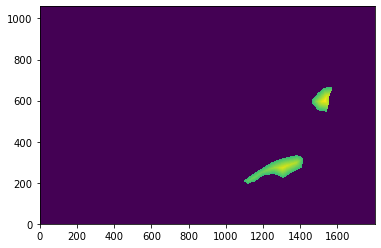

In [121]:
plt.pcolormesh(maximum_filter(all_data["spc_13"]["20210505"], 2))

In [4]:
date_keys = list(all_data["spc_13"].keys())
date_keys.remove('lat')
date_keys.remove('lon')
all_data["spc_13_max"] = {}
all_data["spc_06_max"] = {}
for date in date_keys:
    all_data["spc_13_max"][date] = maximum_filter(all_data["spc_13"][date], 2)
    all_data["spc_06_max"][date] = maximum_filter(all_data["spc_06"][date], 2)

Conditional verification in different parts of CAPE/SHEAR and MAXUVV/SHIP space


In [5]:
class DistributedReliability(object):
    """
    A container for the statistics required to generate reliability diagrams and calculate the Brier Score.
    DistributedReliabilty objects accept binary probabilistic forecasts and associated observations. The
    forecasts are then discretized into the different probability bins. The total frequency and the frequency
    of positive events for each probability bin are tracked. The Brier Score, Brier Skill Score, and
    Brier score components can all be derived from this information. Like the DistributedROC object,
    DistributedReliability objects can be summed together, and their contents can be output as a string.
    Attributes:
        thresholds (numpy.ndarray): Array of probability thresholds
        obs_threshold (float): Split value (>=) for determining positive observation events
        frequencies (pandas.DataFrame): Stores the total and positive frequencies for each bin
    Examples:
        >>> forecasts = np.random.random(1000)
        >>> obs = np.random.random_integers(0, 1, 1000)
        >>> rel = DistributedReliability()
        >>> rel.update(forecasts, obs)
        >>> print(rel.brier_score())
    """

    def __init__(self, thresholds=np.arange(0, 1.1, 0.05), obs_threshold=1.0, input_str=None):
        """
        Initialize the DistributedReliability object.
        Args:
            thresholds (numpy.ndarray): Array of probability thresholds
            obs_threshold (float): Split value for observations
            input_str (str): String containing information to initialize the object from a text representation.
        """
        self.thresholds = thresholds
        self.obs_threshold = obs_threshold
        self.frequencies = pd.DataFrame(np.zeros((self.thresholds.size, 2), dtype=int),
                                        columns=["Total_Freq", "Positive_Freq"])
        if input_str is not None:
            self.from_str(input_str)

    def update(self, forecasts, observations):
        """
        Update the statistics with a set of forecasts and observations.
        Args:
            forecasts (numpy.ndarray): Array of forecast probability values
            observations (numpy.ndarray): Array of observation values
        """
        for t, threshold in enumerate(self.thresholds[:-1]):
            self.frequencies.loc[t, "Positive_Freq"] += np.count_nonzero((threshold <= forecasts) &
                                                                         (forecasts < self.thresholds[t + 1]) &
                                                                         (observations >= self.obs_threshold))
            self.frequencies.loc[t, "Total_Freq"] += np.count_nonzero((threshold <= forecasts) &
                                                                      (forecasts < self.thresholds[t + 1]))

    def clear(self):
        self.frequencies.loc[:, :] = 0

    def __add__(self, other):
        """
        Add two DistributedReliability objects together and combine their values.
        Args:
            other: a DistributedReliability object
        Returns:
            A DistributedReliability Object
        """
        sum_rel = DistributedReliability(self.thresholds, self.obs_threshold)
        sum_rel.frequencies = self.frequencies + other.frequencies
        return sum_rel

    def merge(self, other_rel):
        """
        Ingest another DistributedReliability and add its contents to the current object.
        Args:
            other_rel: a Distributed reliability object.
        """
        if other_rel.thresholds.size == self.thresholds.size and np.all(other_rel.thresholds == self.thresholds):
            self.frequencies += other_rel.frequencies
        else:
            print("Input table thresholds do not match.")

    def reliability_curve(self):
        """
        Calculates the reliability diagram statistics. The key columns are Bin_Start and Positive_Relative_Freq
        Returns:
            pandas.DataFrame
        """
        total = self.frequencies["Total_Freq"].sum()
        curve = pd.DataFrame(columns=["Bin_Start", "Bin_End", "Bin_Center",
                                      "Positive_Relative_Freq", "Total_Relative_Freq"])
        curve["Bin_Start"] = self.thresholds[:-1]
        curve["Bin_End"] = self.thresholds[1:]
        curve["Bin_Center"] = 0.5 * (self.thresholds[:-1] + self.thresholds[1:])
        curve["Positive_Relative_Freq"] = self.frequencies["Positive_Freq"] / self.frequencies["Total_Freq"]
        curve["Total_Relative_Freq"] = self.frequencies["Total_Freq"] / total
        return curve

    def brier_score_components(self):
        """
        Calculate the components of the Brier score decomposition: reliability, resolution, and uncertainty.
        """
        rel_curve = self.reliability_curve()
        total = self.frequencies["Total_Freq"].sum()
        climo_freq = float(self.frequencies["Positive_Freq"].sum()) / self.frequencies["Total_Freq"].sum()
        reliability = np.sum(self.frequencies["Total_Freq"] * (rel_curve["Bin_Start"] -
                                                               rel_curve["Positive_Relative_Freq"]) ** 2) / total
        resolution = np.sum(self.frequencies["Total_Freq"] * (rel_curve["Positive_Relative_Freq"] - climo_freq) ** 2) \
                     / total
        uncertainty = climo_freq * (1 - climo_freq)
        return reliability, resolution, uncertainty

    def climatology(self):
        """
        Calculates the sample climatological relative frequency of the event being forecast.
        """
        return float(self.frequencies["Positive_Freq"].sum()) / self.frequencies["Total_Freq"].sum()

    def brier_score(self):
        """
        Calculate the Brier Score
        """
        reliability, resolution, uncertainty = self.brier_score_components()
        return reliability - resolution + uncertainty

    def brier_skill_score(self):
        """
        Calculate the Brier Skill Score
        """
        reliability, resolution, uncertainty = self.brier_score_components()
        return (resolution - reliability) / uncertainty

    def __str__(self):
        out_str = "Obs_Threshold:{0:0.2f}".format(self.obs_threshold) + ";"
        out_str += "Thresholds:" + " ".join(["{0:0.2f}".format(t) for t in self.thresholds]) + ";"
        for col in self.frequencies.columns:
            out_str += col + ":" + " ".join(["{0:d}".format(t) for t in self.frequencies[col]]) + ";"
        out_str = out_str.rstrip(";")
        return out_str

    def __repr__(self):
        return self.__str__()

    def from_str(self, in_str):
        """
        Updates the object attributes with the information contained in the input string
        Args:
            in_str (str): String output by the __str__ method containing all of the attribute values
        """
        parts = in_str.split(";")
        for part in parts:
            var_name, value = part.split(":")
            if var_name == "Obs_Threshold":
                self.obs_threshold = float(value)
            elif var_name == "Thresholds":
                self.thresholds = np.array(value.split(), dtype=float)
                self.frequencies = pd.DataFrame(columns=self.frequencies.columns,
                                                data=np.zeros((self.thresholds.size,
                                                               self.frequencies.columns.size)))
            elif var_name in ["Positive_Freq", "Total_Freq"]:
                self.frequencies[var_name] = np.array(value.split(), dtype=int)

class DistributedROC(object):
    """
    ROC sparse representation that can be aggregated and can generate ROC curves and performance diagrams.
    A DistributedROC object is given a specified set of thresholds (could be probability or real-valued) and then
    stores a pandas DataFrame of contingency tables for each threshold. The contingency tables are updated with a
    set of forecasts and observations, but the original forecast and observation values are not kept. DistributedROC
    objects can be combined by adding them together or by storing them in an iterable and summing the contents of the
    iterable together. This is especially useful when verifying large numbers of cases in parallel.
    Attributes:
        thresholds (numpy.ndarray): List of probability thresholds in increasing order.
        obs_threshold (float):  Observation values >= obs_threshold are positive events.
        contingency_tables (pandas.DataFrame): Stores contingency table counts for each probability threshold
    Examples:
        >>> import numpy as np
        >>> forecasts = np.random.random(size=1000)
        >>> obs = np.random.random_integers(0, 1, size=1000)
        >>> roc = DistributedROC(thresholds=np.arange(0, 1.1, 0.1), obs_threshold=1)
        >>> roc.update(forecasts, obs)
        >>> print(roc.auc())
    """

    def __init__(self, thresholds=np.arange(0, 1.1, 0.1), obs_threshold=1.0, input_str=None):
        """
        Initializes the DistributedROC object. If input_str is not None, then the DistributedROC object is
         initialized with the contents of input_str. Otherwise an empty contingency table is created.
        Args:
            thresholds (numpy.array): Array of thresholds in increasing order.
            obs_threshold (float): Split threshold (>= is positive event) (< is negative event)
            input_str (None or str): String containing information for DistributedROC
        """
        self.thresholds = thresholds
        self.obs_threshold = obs_threshold
        self.contingency_tables = pd.DataFrame(np.zeros((thresholds.size, 4), dtype=int),
                                               columns=["TP", "FP", "FN", "TN"])
        if input_str is not None:
            self.from_str(input_str)

    def update(self, forecasts, observations):
        """
        Update the ROC curve with a set of forecasts and observations
        Args:
            forecasts: 1D array of forecast values
            observations: 1D array of observation values.
        """
        for t, threshold in enumerate(self.thresholds):
            tp = np.count_nonzero((forecasts >= threshold) & (observations >= self.obs_threshold))
            fp = np.count_nonzero((forecasts >= threshold) &
                                  (observations < self.obs_threshold))
            fn = np.count_nonzero((forecasts < threshold) &
                                  (observations >= self.obs_threshold))
            tn = np.count_nonzero((forecasts < threshold) &
                                  (observations < self.obs_threshold))
            self.contingency_tables.iloc[t] += [tp, fp, fn, tn]

    def clear(self):
        self.contingency_tables.loc[:, :] = 0

    def __add__(self, other):
        """
        Add two DistributedROC objects together and combine their contingency table values.
        Args:
            other: Another DistributedROC object.
        """
        sum_roc = DistributedROC(self.thresholds, self.obs_threshold)
        sum_roc.contingency_tables = self.contingency_tables + other.contingency_tables
        return sum_roc

    def merge(self, other_roc):
        """
        Ingest the values of another DistributedROC object into this one and update the statistics inplace.
        Args:
            other_roc: another DistributedROC object.
        """
        if other_roc.thresholds.size == self.thresholds.size and np.all(other_roc.thresholds == self.thresholds):
            self.contingency_tables += other_roc.contingency_tables
        else:
            print("Input table thresholds do not match.")

    def roc_curve(self):
        """
        Generate a ROC curve from the contingency table by calculating the probability of detection (TP/(TP+FN)) and the
        probability of false detection (FP/(FP+TN)).
        Returns:
            A pandas.DataFrame containing the POD, POFD, and the corresponding probability thresholds.
        """
        pod = self.contingency_tables["TP"].astype(float) / (self.contingency_tables["TP"] +
                                                             self.contingency_tables["FN"])
        pofd = self.contingency_tables["FP"].astype(float) / (self.contingency_tables["FP"] +
                                                              self.contingency_tables["TN"])
        return pd.DataFrame({"POD": pod, "POFD": pofd, "Thresholds": self.thresholds},
                            columns=["POD", "POFD", "Thresholds"])

    def performance_curve(self):
        """
        Calculate the Probability of Detection and False Alarm Ratio in order to output a performance diagram.
        Returns:
            pandas.DataFrame containing POD, FAR, and probability thresholds.
        """
        pod = self.contingency_tables["TP"] / (self.contingency_tables["TP"] + self.contingency_tables["FN"])
        far = self.contingency_tables["FP"] / (self.contingency_tables["FP"] + self.contingency_tables["TP"])
        far[(self.contingency_tables["FP"] + self.contingency_tables["TP"]) == 0] = np.nan
        return pd.DataFrame({"POD": pod, "FAR": far, "Thresholds": self.thresholds},
                            columns=["POD", "FAR", "Thresholds"])

    def auc(self):
        """
        Calculate the Area Under the ROC Curve (AUC).
        """
        roc_curve = self.roc_curve()
        return np.abs(np.trapz(roc_curve['POD'], x=roc_curve['POFD']))

    def max_csi(self):
        """
        Calculate the maximum Critical Success Index across all probability thresholds
        Returns:
            The maximum CSI as a float
        """
        csi = self.contingency_tables["TP"] / (self.contingency_tables["TP"] + self.contingency_tables["FN"] +
                                               self.contingency_tables["FP"])
        return csi.max()

    def max_threshold_score(self, score="ets"):
        cts = self.get_contingency_tables()
        scores = np.array([getattr(ct, score)() for ct in cts])
        return self.thresholds[scores.argmax()], scores.max()

    def get_contingency_tables(self):
        """
        Create an Array of ContingencyTable objects for each probability threshold.
        Returns:
            Array of ContingencyTable objects
        """
        return np.array([ContingencyTable(*ct) for ct in self.contingency_tables.values])

    def __str__(self):
        """
        Output the information within the DistributedROC object to a string.
        """
        out_str = "Obs_Threshold:{0:0.2f}".format(self.obs_threshold) + ";"
        out_str += "Thresholds:" + " ".join(["{0:0.2f}".format(t) for t in self.thresholds]) + ";"
        for col in self.contingency_tables.columns:
            out_str += col + ":" + " ".join(["{0:d}".format(t) for t in self.contingency_tables[col]]) + ";"
        out_str = out_str.rstrip(";")
        return out_str

    def __repr__(self):
        return self.__str__()

    def from_str(self, in_str):
        """
        Read the DistributedROC string and parse the contingency table values from it.
        Args:
            in_str (str): The string output from the __str__ method
        """
        parts = in_str.split(";")
        for part in parts:
            var_name, value = part.split(":")
            if var_name == "Obs_Threshold":
                self.obs_threshold = float(value)
            elif var_name == "Thresholds":
                self.thresholds = np.array(value.split(), dtype=float)
                self.contingency_tables = pd.DataFrame(columns=self.contingency_tables.columns,
                                                       data=np.zeros((self.thresholds.size,
                                                                      self.contingency_tables.columns.size)))
            elif var_name in self.contingency_tables.columns:
                self.contingency_tables[var_name] = np.array(value.split(), dtype=int)

def bootstrap(score_objs, n_boot=1000):
    """
    Given a set of DistributedROC or DistributedReliability objects, this function performs a
    bootstrap resampling of the objects and returns n_boot aggregations of them.
    Args:
        score_objs: A list of DistributedROC or DistributedReliability objects. Objects must have an __add__ method
        n_boot (int): Number of bootstrap samples
    Returns:
        An array of DistributedROC or DistributedReliability
    """
    all_samples = np.random.choice(score_objs, size=(n_boot, len(score_objs)), replace=True)
    return all_samples.sum(axis=1)

In [6]:
var_comp_dfs = []
print(list(all_data["href"]["MLCAPE"].keys()))
href_vars_short
var_comp_day = {}
stride = 13
for date in all_data["href"]["MLCAPE"].keys():
    print(date)
    var_comp_day["lon"] = all_data["burke_dl"]["lon"][::stride,::stride].ravel()
    var_comp_day["lat"] = all_data["burke_dl"]["lat"][::stride,::stride].ravel()
    for k in ['burke_dl', 'burke_rf', 'loken_rf', 'spc_06_max', 'spc_13_max', 'lsr']:
        var_comp_day[k] = all_data[k][date][::stride, ::stride].ravel()
    for k in all_data["href"].keys():
        var_comp_day[k] = gaussian_filter(all_data["href"][k][date], 13)[::stride, ::stride].ravel()
    var_comp_day_df = pd.DataFrame(var_comp_day)
    var_comp_dfs.append(var_comp_day_df)
    var_comp_day_df.to_csv(f"/glade/p/cisl/aiml/hail/summary_csv/summary_{date}.csv")
var_comp_all = pd.concat(var_comp_dfs)

['20210503', '20210504', '20210505', '20210506', '20210507', '20210508', '20210509', '20210510', '20210511', '20210512', '20210513', '20210514', '20210515', '20210516', '20210517', '20210518', '20210519', '20210520', '20210521', '20210522', '20210523', '20210524', '20210525', '20210526', '20210527', '20210528', '20210529', '20210530', '20210531', '20210601', '20210602', '20210603', '20210604', '20210605', '20210606', '20210607', '20210608', '20210609', '20210610', '20210611', '20210612', '20210613', '20210614', '20210615', '20210616', '20210617', '20210618', '20210619', '20210620', '20210621', '20210622', '20210623', '20210624', '20210625', '20210626', '20210627', '20210628', '20210629', '20210630', '20210701', '20210702', '20210703', '20210704', '20210705', '20210706', '20210707', '20210708', '20210709', '20210710', '20210711', '20210712', '20210713', '20210714', '20210715', '20210716', '20210717', '20210718', '20210719', '20210720', '20210721', '20210722', '20210723', '20210724', '20

NameError: name 'gaussian_filter' is not defined

In [11]:
var_comp_all

,lon,lat,burke_dl,burke_rf,loken_rf,spc_06_max,spc_13_max,lsr,MLCAPE,magSHEAR10_500mb,LR75,MXUPHL5_2,MAXUVV,SHIP,SCP
0,-122.720001,21.138000,0.0,0.0,0.0,0.0,0.0,0.0,6.206686,7.406775,5.078125,-0.003128,0.200267,0.000012,0.000000
1,-122.372993,21.228289,0.0,0.0,0.0,0.0,0.0,0.0,6.134373,7.323709,5.078125,-0.003128,0.202321,0.000012,0.000000
2,-122.025269,21.317394,0.0,0.0,0.0,0.0,0.0,0.0,5.884714,7.161972,5.078125,-0.003128,0.205515,0.000012,0.000000
3,-121.676819,21.405312,0.0,0.0,0.0,0.0,0.0,0.0,5.597221,7.010831,5.078125,-0.003128,0.207597,0.000011,0.000000
4,-121.327660,21.492037,0.0,0.0,0.0,0.0,0.0,0.0,5.384943,6.902470,5.078125,-0.003128,0.208490,0.000011,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11393,-63.056557,48.279541,0.0,0.0,0.0,0.0,0.0,0.0,176.754150,11.130011,5.750000,0.041616,0.704882,0.035781,0.070552
11394,-62.574509,48.152424,0.0,0.0,0.0,0.0,0.0,0.0,208.463074,11.417940,5.750000,0.052076,0.789220,0.050358,0.108065
11395,-62.094467,48.023579,0.0,0.0,0.0,0.0,0.0,0.0,246.691620,12.185169,5.750000,0.075091,0.899226,0.068147,0.175877
11396,-61.616444,47.893009,0.0,0.0,0.0,0.0,0.0,0.0,280.662872,13.188584,5.750000,0.082539,0.960832,0.087344,0.267110


In [13]:
np.count_nonzero(var_comp_all["loken_rf"] > 0)

83785

## XAI Emulator Analysis
How can we link sensitivities of different HREF inputs to the forecast system predictions? 

In [15]:
rfs = {}
rf_targets = ["spc_06_max", "spc_13_max", "burke_rf", "loken_rf", "burke_dl"]
rf_inputs = ["lon", "lat"] + href_vars_short
rf_rows = var_comp_all["loken_rf"] > 0
for rf_target in rf_targets:
    rfs[rf_target] = RandomForestRegressor(n_jobs=8, n_estimators=32, max_features="sqrt", max_depth=10)
    rfs[rf_target].fit(var_comp_all.loc[rf_rows, rf_inputs].values, var_comp_all.loc[rf_rows, rf_target])

In [19]:
importances = np.zeros((len(rf_inputs), len(rf_targets)))
m = 0
for mod_name, mod in rfs.items():
    importances[:, m] = mod.feature_importances_
    m += 1

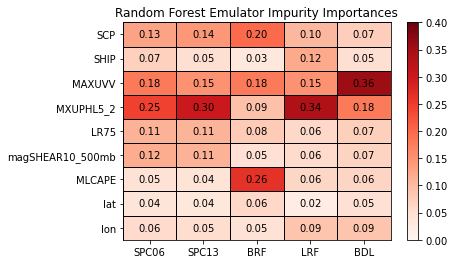

In [21]:
plt.pcolormesh(importances, cmap='Reds', vmax=0.4, vmin=0, edgecolor="k")
for (i,j), v in np.ndenumerate(importances):
    plt.text(j + 0.5, i + 0.5, f"{v:0.2f}", ha="center", va="center")
plt.colorbar()
plt.yticks(np.arange(len(rf_inputs)) + 0.5, rf_inputs)
plt.xticks(np.arange(5) + 0.5, ["SPC06", "SPC13", "BRF", "LRF", "BDL"])
plt.title("Random Forest Emulator Impurity Importances")
plt.savefig("em_impurity_importances.png", dpi=200, bbox_inches="tight")

In [34]:
from sklearn.inspection import partial_dependence
pd_outs = {}
for v, var in enumerate(rf_inputs):
    pd_outs[var] = {}
    for m, mod in rfs.items():
        pd_outs[var][m] = partial_dependence(mod, var_comp_all.loc[rf_rows, rf_inputs].values,[v], percentiles=[0, 1])

/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/sklearn/inspection/_partial_dependence.py:518: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


In [30]:
rf_inputs

['lon',
 'lat',
 'MLCAPE',
 'magSHEAR10_500mb',
 'LR75',
 'MXUPHL5_2',
 'MAXUVV',
 'SHIP',
 'SCP']

In [25]:
var_comp_all[href_vars_short].max()

MLCAPE              4906.741211
magSHEAR10_500mb      52.541073
LR75                   9.812500
MXUPHL5_2             60.175449
MAXUVV                18.758862
SHIP                   0.808955
SCP                   33.648991
dtype: float32

In [42]:
pd_outs["lon"]["spc_06_max"][1]

[array([-123.81428528, -123.24869684, -122.6831084 , -122.11751996,
        -121.55193152, -120.98634308, -120.42075463, -119.85516619,
        -119.28957775, -118.72398931, -118.15840087, -117.59281243,
        -117.02722399, -116.46163555, -115.89604711, -115.33045867,
        -114.76487023, -114.19928179, -113.63369335, -113.06810491,
        -112.50251647, -111.93692803, -111.37133959, -110.80575115,
        -110.2401627 , -109.67457426, -109.10898582, -108.54339738,
        -107.97780894, -107.4122205 , -106.84663206, -106.28104362,
        -105.71545518, -105.14986674, -104.5842783 , -104.01868986,
        -103.45310142, -102.88751298, -102.32192454, -101.7563361 ,
        -101.19074766, -100.62515922, -100.05957077,  -99.49398233,
         -98.92839389,  -98.36280545,  -97.79721701,  -97.23162857,
         -96.66604013,  -96.10045169,  -95.53486325,  -94.96927481,
         -94.40368637,  -93.83809793,  -93.27250949,  -92.70692105,
         -92.14133261,  -91.57574417,  -91.01015

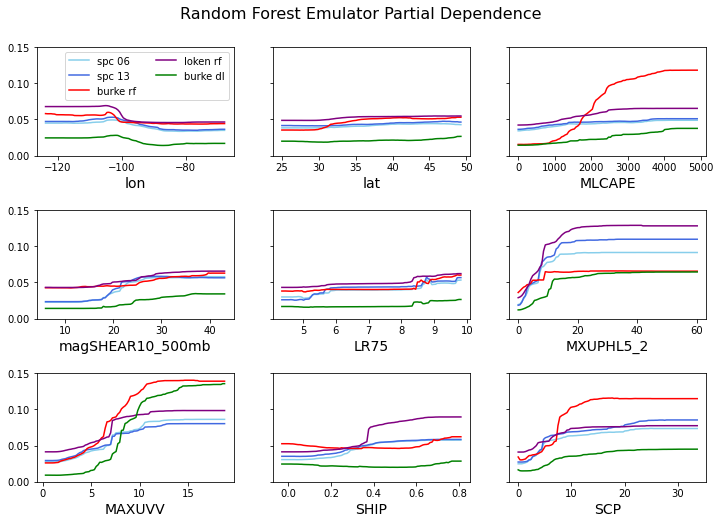

In [64]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8), sharey=True)
plt.subplots_adjust(hspace=0.5)
mod_names = ["SPC06", "SPC13", "BRF", "LRF", "BDL"]
colors = ["skyblue", "royalblue", "red", "purple", "green"]
for a, ax in enumerate(axes.ravel()):
    for m, mod_name in enumerate(pd_outs[rf_inputs[a]].keys()):
        ax.plot(pd_outs[rf_inputs[a]][mod_name][1][0],pd_outs[rf_inputs[a]][mod_name][0][0], 
                colors[m], 
                label=mod_name.replace("_", " ").replace("max", ""))
    ax.set_xlabel(rf_inputs[a], fontsize=14)
    if a == 0:
        ax.legend(ncol=2)
    ax.set_yticks(np.arange(0, 0.2, 0.05))
plt.suptitle("Random Forest Emulator Partial Dependence", y=0.95, fontsize=16)
plt.savefig("rf_partial_dependence.png", dpi=200, bbox_inches="tight")

In [218]:
pd_outs_map = []
for m, mod in enumerate([rf_spc_06, rf_spc_13, rf_burke_rf, rf_loken_rf, rf_burke_dl]):
    pd_outs_map.append(partial_dependence(mod, var_comp_all[["lon", "lat"] + href_vars_short].values, [(0, 1)], percentiles=[0, 1]), )


/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/sklearn/utils/__init__.py:201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return array[key] if axis == 0 else array[:, key]
/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/sklearn/inspection/_partial_dependence.py:518: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


In [144]:
spc_preds = rf.predict(var_comp_all[["lon", "lat"] + href_vars_short].values)

In [65]:
plt.scatter(spc_preds, var_comp_all["spc_13_max"])

NameError: name 'spc_preds' is not defined

In [149]:
in_cols = ["lon", "lat"] + href_vars_short
for i, fi in enumerate(rf.feature_importances_):
    print(in_cols[i], fi)

lon 0.062299382681083315
lat 0.1015320247120339
MLCAPE 0.02860694120419028
magSHEAR10_500mb 0.06728110680381079
LR75 0.11605118940601726
MXUPHL5_2 0.27791756672317136
MAXUVV 0.13484802765892848
SHIP 0.05985799154852052
SCP 0.151605769262244


In [24]:
import sklearn
sklearn.__version__

'1.0'

In [40]:
probs = rf.predict_proba(var_comp_all[["lon", "lat"] + href_vars_short].values)
labels = rf.predict(var_comp_all[["lon", "lat"] + href_vars_short].values)

In [29]:
var_comp_labels.shape

(1196790, 4)

In [43]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(var_comp_labels_small, labels)
print(cf)

[[1086365       1    3819    1027]
 [   8335     118     240     747]
 [  26135       1   23599    6907]
 [   7509       2    6474   25511]]


In [47]:
pd_out = partial_dependence(rf, var_comp_all[["lon", "lat"] + href_vars_short].values, [0, 1],
                  grid_resolution=10)

/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/sklearn/inspection/_partial_dependence.py:518: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


In [65]:
href_vars_short

['MLCAPE', 'magSHEAR10_500mb', 'LR75', 'MXUPHL5_2', 'MAXUVV', 'SHIP', 'SCP']

In [ ]:
pd_out = partial_dependence(rf, var_comp_all[["lon", "lat"] + href_vars_short].values, [0, 1],
                  grid_resolution=10)

In [56]:
pd_out[1]

[array([-125.10696411, -118.98869663, -112.87042914, -106.75216166,
        -100.63389418,  -94.5156267 ,  -88.39735921,  -82.27909173,
         -76.16082425,  -70.04255676]),
 array([24.45429802, 27.27897644, 30.10365486, 32.92833328, 35.7530117 ,
        38.57769012, 41.40236855, 44.22704697, 47.05172539, 49.87640381])]

NameError: name 'pd_out' is not defined

/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


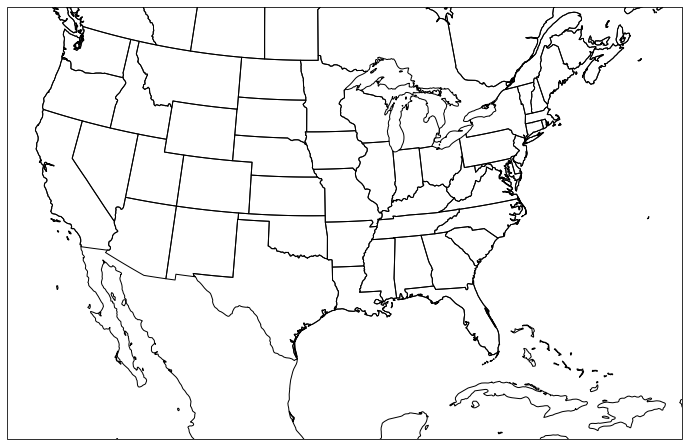

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 6))
proj = ccrs.LambertConformal()
ax = fig.add_axes([0, 0, 1, 1], projection=proj)
ax.set_extent([-120, -66.5, 20, 50], ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)

out = ax.pcolormesh(pd_out[1][0],pd_out[1][1], pd_out[0][3], transform=ccrs.PlateCarree())
plt.colorbar(out)

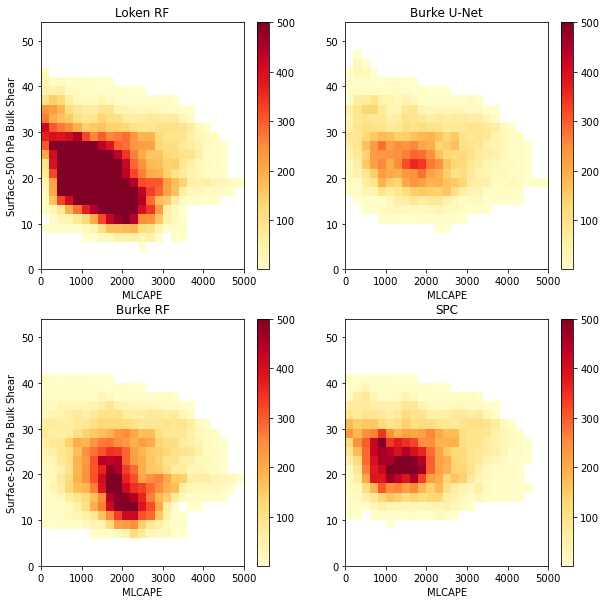

In [240]:
cape_bins = np.arange(0, 5100, 200)
shear_bins = np.arange(0, 55, 2)
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.hist2d(var_comp_all.loc[var_comp_all["loken_rf"] > 0.01, "MLCAPE"], 
           var_comp_all.loc[var_comp_all["loken_rf"] > 0.01, "magSHEAR10_500mb"], bins=(cape_bins, shear_bins), 
           cmin=1,cmap="YlOrRd", alpha=1, vmax=500)
plt.xlabel("MLCAPE")
plt.ylabel("Surface-500 hPa Bulk Shear")
plt.title("Loken RF")

plt.colorbar()
plt.subplot(2, 2, 2)
plt.hist2d(var_comp_all.loc[var_comp_all["burke_dl"] > 0.01, "MLCAPE"], 
           var_comp_all.loc[var_comp_all["burke_dl"] > 0.01, "magSHEAR10_500mb"], bins=(cape_bins, shear_bins), 
           cmin=1, cmap="YlOrRd", alpha=1, vmax=500)
plt.xlabel("MLCAPE")
plt.title("Burke U-Net")
plt.colorbar()

plt.subplot(2, 2, 3)
plt.hist2d(var_comp_all.loc[var_comp_all["burke_rf"] > 0.01, "MLCAPE"], 
           var_comp_all.loc[var_comp_all["burke_rf"] > 0.01, "magSHEAR10_500mb"], bins=(cape_bins, shear_bins), 
           cmin=1, cmap="YlOrRd", alpha=1, vmax=500)

plt.xlabel("MLCAPE")
plt.title("Burke RF")
plt.ylabel("Surface-500 hPa Bulk Shear")

plt.colorbar()
plt.subplot(2, 2, 4)
plt.hist2d(var_comp_all.loc[var_comp_all["spc_13_max"] > 0.01, "MLCAPE"], 
           var_comp_all.loc[var_comp_all["spc_13_max"] > 0.01, "magSHEAR10_500mb"], bins=(cape_bins, shear_bins), 
           cmin=1, cmap="YlOrRd", alpha=1, vmax=500)
plt.xlabel("MLCAPE")
plt.title("SPC")
plt.colorbar()
plt.savefig("cape_shear_comp.png", bbox_inches="tight", dpi=300)

(array([[ nan,  nan,   3.,  14.,  41., 135., 117.,  31.,   3.,  nan],
        [ nan,  nan,   5.,  54.,  83., 182., 100.,  42.,   4.,  nan],
        [ nan,  nan,  25., 136., 221., 230., 136.,  64.,   1.,  nan],
        [ nan,  nan,  35., 228., 337., 333., 123.,  29.,   1.,  nan],
        [ nan,   4.,  61., 291., 359., 341.,  94.,  18.,   5.,  nan],
        [ nan,  nan,  66., 333., 422., 282.,  70.,  17.,   2.,  nan],
        [ nan,  nan,  64., 305., 509., 296.,  91.,  24.,   1.,  nan],
        [ nan,  nan,  60., 301., 492., 267., 115.,  34.,   1.,  nan],
        [ nan,  nan,  55., 312., 460., 292.,  97.,  26.,   1.,  nan],
        [ nan,  nan,  49., 278., 447., 242.,  81.,  15.,  nan,  nan],
        [ nan,   1.,  67., 224., 326., 264.,  70.,  14.,  nan,  nan],
        [ nan,  nan,  59., 200., 226., 194.,  77.,   9.,  nan,  nan],
        [ nan,   1.,  40., 155., 191., 180.,  65.,   9.,  nan,  nan],
        [ nan,  nan,  36., 155., 144., 146.,  58.,   8.,  nan,  nan],
        [ nan,  nan,

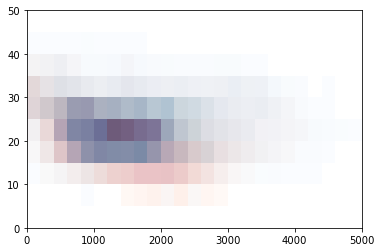

In [109]:
cape_bins = np.arange(0, 5100, 200)
shear_bins = np.arange(0, 55, 5)
plt.hist2d(var_comp_all.loc[var_comp_all["loken_rf"] > 0.01, "MLCAPE"], 
           var_comp_all.loc[var_comp_all["loken_rf"] > 0.01, "magSHEAR10_500mb"], bins=(cape_bins, shear_bins), cmin=100,cmap="Reds", alpha=0.5)
plt.hist2d(var_comp_all.loc[var_comp_all["spc_nws"] > 0.01, "MLCAPE"], 
           var_comp_all.loc[var_comp_all["spc_nws"] > 0.01, "magSHEAR10_500mb"], bins=(cape_bins, shear_bins), cmin=1, cmap="Blues", alpha=0.5)

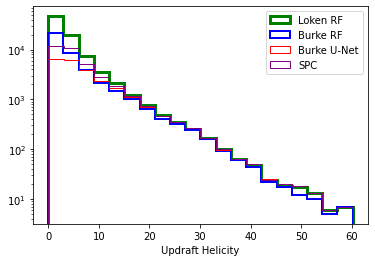

In [243]:
plt.hist(var_comp_all.loc[var_comp_all["loken_rf"] > 0.01, "MXUPHL5_2"], bins=20, density=False, histtype="step", linewidth=3, color="green", label="Loken RF")
plt.hist(var_comp_all.loc[var_comp_all["burke_rf"] > 0.01, "MXUPHL5_2"], bins=20, density=False, histtype="step", linewidth=2, color="blue", label="Burke RF")
plt.hist(var_comp_all.loc[var_comp_all["burke_dl"] > 0.01, "MXUPHL5_2"], bins=20, density=False, histtype="step", color="red", label="Burke U-Net")
plt.hist(var_comp_all.loc[var_comp_all["spc_13_max"] > 0.01, "MXUPHL5_2"], bins=20, density=False, histtype="step", color="purple", label="SPC")
plt.legend()
plt.gca().set_yscale("log")
plt.xlabel("Updraft Helicity")
plt.savefig("uh_hist_comp.png", dpi=200, bbox_inches="tight")

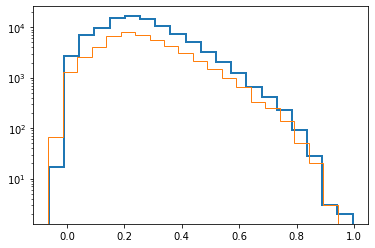

In [124]:
plt.hist(var_comp_all.loc[var_comp_all["loken_rf"] > 0.01, "SHIP"], bins=20, density=False, histtype="step", linewidth=2)
plt.hist(var_comp_all.loc[var_comp_all["burke_rf"] > 0.01, "SHIP"], bins=20, density=False, histtype="step")
plt.gca().set_yscale("log")

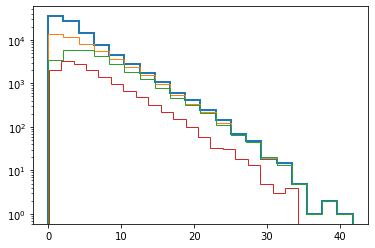

In [127]:
plt.hist(var_comp_all.loc[var_comp_all["loken_rf"] > 0.01, "SCP"], bins=20, density=False, histtype="step", linewidth=2)
plt.hist(var_comp_all.loc[var_comp_all["burke_rf"] > 0.01, "SCP"], bins=20, density=False, histtype="step")
plt.hist(var_comp_all.loc[var_comp_all["burke_dl"] > 0.01, "SCP"], bins=20, density=False, histtype="step")
plt.hist(var_comp_all.loc[var_comp_all["spc_nws"] > 0.01, "SCP"], bins=20, density=False, histtype="step")

plt.gca().set_yscale("log")

In [119]:
us_mask = xr.open_dataset("../mapfiles/hrefv2_us_mask_djg.nc")

In [125]:
us_mask["usa_mask"].values.ravel()

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

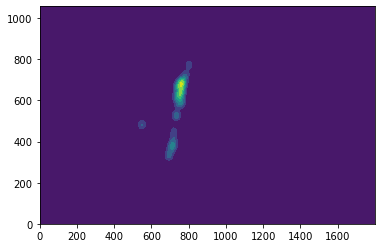

In [123]:
plt.contourf(all_data["burke_dl"]["20210521"] * us_mask["usa_mask"])

In [13]:
us_mask = xr.open_dataset("../mapfiles/hrefv2_us_mask_djg.nc")
f_mask = us_mask["usa_mask"].values
lsr_dates = sorted(list(all_data["lsr"].keys()))[:-2]
forecasts = ["spc_06_max", "spc_13_max", "burke_rf", "loken_rf", "burke_dl"]
#forecasts = ['burke_dl', 'burke_rf', 'loken_rf', 'spc_06_max', 'spc_13_max']
thresholds = np.array([0, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7])
drocs = {f: [] for f in forecasts}
drels = {f: [] for f in forecasts}
final_lsr_dates = []
for lsr_date in lsr_dates:
    print(lsr_date)
    all_avail = []
    for mod in forecasts:
        all_avail.append(lsr_date in all_data[mod].keys())
    if all(all_avail) and all_data["lsr"][lsr_date].max() > 0:
        final_lsr_dates.append(lsr_date)
        idx = (f_mask > 0) & (all_data["href"]["MAXUVV"][lsr_date] > 10)
        for mod in forecasts:
            print(mod)
            if lsr_date in all_data[mod].keys():
                drocs[mod].append(DistributedROC(thresholds=thresholds))
                drocs[mod][-1].update(all_data[mod][lsr_date][idx], all_data["lsr"][lsr_date][idx])
                drels[mod].append(DistributedReliability(thresholds=thresholds))
                drels[mod][-1].update(all_data[mod][lsr_date][idx], all_data["lsr"][lsr_date][idx])

            

20210503
spc_06_max
spc_13_max
burke_rf
loken_rf
burke_dl
20210504
spc_06_max
spc_13_max
burke_rf
loken_rf
burke_dl
20210505
spc_06_max
spc_13_max
burke_rf
loken_rf
burke_dl
20210506
spc_06_max
spc_13_max
burke_rf
loken_rf
burke_dl
20210507
spc_06_max
spc_13_max
burke_rf
loken_rf
burke_dl
20210508
spc_06_max
spc_13_max
burke_rf
loken_rf
burke_dl
20210509
spc_06_max
spc_13_max
burke_rf
loken_rf
burke_dl
20210510
spc_06_max
spc_13_max
burke_rf
loken_rf
burke_dl
20210511
spc_06_max
spc_13_max
burke_rf
loken_rf
burke_dl
20210512
20210513
spc_06_max
spc_13_max
burke_rf
loken_rf
burke_dl
20210514
spc_06_max
spc_13_max
burke_rf
loken_rf
burke_dl
20210515
spc_06_max
spc_13_max
burke_rf
loken_rf
burke_dl
20210516
spc_06_max
spc_13_max
burke_rf
loken_rf
burke_dl
20210517
spc_06_max
spc_13_max
burke_rf
loken_rf
burke_dl
20210518
spc_06_max
spc_13_max
burke_rf
loken_rf
burke_dl
20210519
spc_06_max
spc_13_max
burke_rf
loken_rf
burke_dl
20210520
spc_06_max
spc_13_max
burke_rf
loken_rf
burke_dl
20210

In [128]:
total_rocs = []
total_rels = []
boot_rocs = []
boot_rels = []
for mod in forecasts:
    print(mod)
    total_rocs.append(np.sum(drocs[mod]))
    boot_rocs.append(bootstrap(drocs[mod]))
    total_rels.append(np.sum(drels[mod]))
    boot_rels.append(bootstrap(drels[mod]))

spc_06_max
spc_13_max
burke_rf
loken_rf
burke_dl


In [25]:
list(drocs.keys())

['burke_dl', 'burke_rf', 'loken_rf', 'spc_1', 'spc_2']

In [14]:
droc_df = pd.DataFrame(drocs, index=pd.DatetimeIndex(final_lsr_dates))
drel_df = pd.DataFrame(drels, index=pd.DatetimeIndex(final_lsr_dates))

In [15]:
month_rocs = droc_df.groupby(droc_df.index.month).sum()
month_rels = drel_df.groupby(drel_df.index.month).sum()

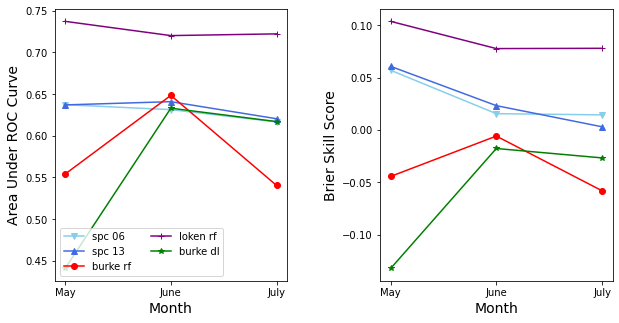

In [16]:
colors = ["skyblue", "royalblue", "red", "purple", "green"]
syms = ['v', '^', 'o', '+', '*']
plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.4)
plt.subplot(1, 2, 1)
for c, col in enumerate(month_rocs.columns):
    aucs = [month_rocs.loc[m, col].auc() for m in month_rocs.index]
    plt.plot(month_rocs.index, aucs, color=colors[c], label=col.replace("_", " ").replace("max", ""), marker=syms[c])
plt.legend(loc=3, ncol=2)
plt.xticks(np.arange(5, 8), ["May", "June", "July"])
plt.ylabel("Area Under ROC Curve", fontsize=14)
plt.xlabel("Month", fontsize=14)

plt.subplot(1, 2, 2)
for c, col in enumerate(month_rocs.columns):
    bsss = [month_rels.loc[m, col].brier_skill_score() for m in month_rocs.index]
    plt.plot(month_rocs.index, bsss, color=colors[c], label=col.replace("_", " ").replace("max", ""), marker=syms[c])
#plt.legend(loc=3, ncol=2)
plt.xticks(np.arange(5, 8), ["May", "June", "July"])
plt.ylabel("Brier Skill Score", fontsize=14)
plt.xlabel("Month", fontsize=14)
plt.savefig("monthly_auc_bss.png", dpi=200, bbox_inches="tight")

In [132]:
f_names = [col.replace("_", " ").replace("max", "") for col in month_rocs.columns]
performance_diagram(total_rocs, f_names, colors, syms, 
                    "hail_perf_2021_may_july.png", bootstrap_sets=boot_rocs, title="HWT 2021 Hail Performance")

/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/hagelslag/evaluation/MetricPlotter.py:132: RuntimeWarning: divide by zero encountered in true_divide
  bias = pod_g / sr_g
/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/hagelslag/evaluation/MetricPlotter.py:132: RuntimeWarning: invalid value encountered in true_divide
  bias = pod_g / sr_g
/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/hagelslag/evaluation/MetricPlotter.py:133: RuntimeWarning: divide by zero encountered in true_divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)
/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/gla

In [133]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition

attributes_diagram(total_rels, f_names, colors, syms, 
                   "hail_attr_2021_extended.png", bootstrap_sets=boot_rels, title="HWT 2021 Hail Reliability")

/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [105]:
for f, forecast in enumerate(forecasts):
    print(forecast, total_rels[f].brier_skill_score())

spc_06_max 0.07356175732176909
spc_13_max 0.08149136632070805
burke_rf 0.018596941494145997
loken_rf 0.11301248297804858
burke_dl 0.03275389736905031


In [106]:
for f, forecast in enumerate(forecasts):
    rel_comps = total_rels[f].brier_score_components()
    print(forecast, rel_comps[0] / rel_comps[2], rel_comps[1] / rel_comps[2])

spc_06_max 0.005854754367655531 0.07941651168942461
spc_13_max 0.00666201616126842 0.08815338248197647
burke_rf 0.029962924743655875 0.04855986623780187
loken_rf 0.0029609539763675876 0.11597343695441617
burke_dl 0.013761341230908612 0.046515238599958916


In [108]:
proj_params = {'a': 6371229.0,
 'b': 6371229.0,
 'proj': 'lcc',
 'lon_0': 262.5,
 'lat_0': 38.5,
 'lat_1': 38.5,
 'lat_2': 38.5}

/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


Text(0.5, 1.0, 'ML Hail Composite 20210525')

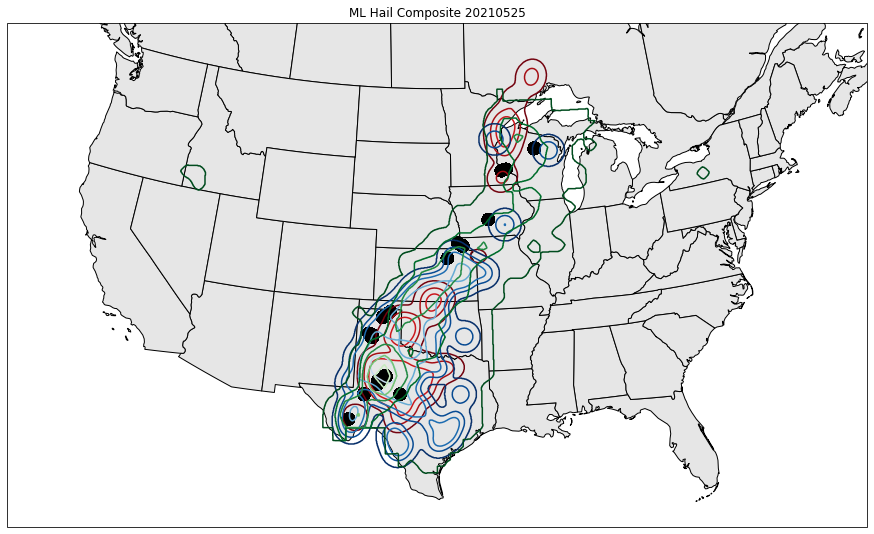

In [42]:
plot_date = "20210525"
fig = plt.figure(figsize=(12, 7))
ax = fig.add_axes([0, 0, 1, 1], 
                  projection=ccrs.LambertConformal(central_latitude=proj_params["lat_0"],
                                                   central_longitude=proj_params["lon_0"],
                                                   standard_parallels=[proj_params["lat_1"], proj_params["lat_2"]]
                                                  ))
ax.add_feature(cfs.STATES, facecolor="0.9", zorder=0)
ax.contourf(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], all_data["lsr"][plot_date], np.array([0.5, 1]), 
            transform=ccrs.PlateCarree(), cmap="binary", vmax=0.5, vmin=-1)
ax.contour(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], all_data["burke_dl"][plot_date], np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4]), 
            transform=ccrs.PlateCarree(), cmap="Reds_r", vmax=0.4, vmin=0)
ax.contour(all_data["burke_rf"]["lon"], all_data["burke_rf"]["lat"], all_data["burke_rf"][plot_date], np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4]), 
            transform=ccrs.PlateCarree(), cmap="Blues_r")
ax.contour(all_data["loken_rf"]["lon"], all_data["loken_rf"]["lat"], all_data["loken_rf"][plot_date], np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4]), 
            transform=ccrs.PlateCarree(), cmap="Greens_r", vmax=0.4, vmin=0)

#ax.contour(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], all_data["spc_nws"][plot_date], np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4]), 
#            transform=ccrs.PlateCarree(), cmap="Purples_r", vmax=0.4, vmin=0)
ax.set_title("ML Hail Composite " + plot_date)

/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/work/dgagne/miniconda3/envs/hag/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


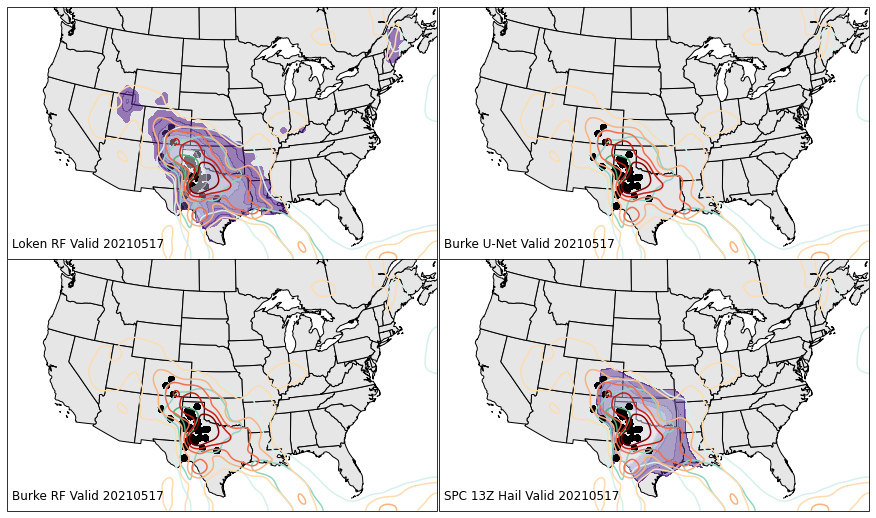

In [118]:
plot_date = "20210517"
contours = np.array([0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.3, 0.45])
fig = plt.figure(figsize=(12, 7))
ax = fig.add_axes([0, 0.5, 0.5, 0.5], 
                  projection=ccrs.LambertConformal(central_latitude=proj_params["lat_0"],
                                                   central_longitude=proj_params["lon_0"],
                                                   standard_parallels=[proj_params["lat_1"], proj_params["lat_2"]]
                                                  ))
ax.add_feature(cfs.STATES, facecolor="0.9", zorder=0)
ax.contourf(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], all_data["lsr"][plot_date], np.array([0.5, 1]), 
            transform=ccrs.PlateCarree(), cmap="binary", vmax=0.5, vmin=-1)
ax.contourf(all_data["loken_rf"]["lon"], all_data["loken_rf"]["lat"], all_data["loken_rf"][plot_date],  contours, 
            transform=ccrs.PlateCarree(), cmap="Purples_r", vmax=0.45, vmin=0, alpha=0.5)
shipc = ax.contour(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], gaussian_filter(all_data["href"]["SHIP"][plot_date], 20), np.arange(0.2, 1, 0.2), 
            transform=ccrs.PlateCarree(), cmap="BuGn", vmin=0, vmax=1)
uvvc = ax.contour(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], gaussian_filter(all_data["href"]["MAXUVV"][plot_date], 20), np.arange(2, 12, 2), 
            transform=ccrs.PlateCarree(), cmap="OrRd", vmin=0, vmax=10)
ax.set_title("Loken RF Valid " + plot_date, loc="left", y=0.02, x=0.01)
ax = fig.add_axes([0.5, 0.5, 0.5, 0.5], 
                  projection=ccrs.LambertConformal(central_latitude=proj_params["lat_0"],
                                                   central_longitude=proj_params["lon_0"],
                                                   standard_parallels=[proj_params["lat_1"], proj_params["lat_2"]]
                                                  ))
ax.add_feature(cfs.STATES, facecolor="0.9", zorder=0)
ax.contourf(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], all_data["lsr"][plot_date], np.array([0.5, 1]), 
            transform=ccrs.PlateCarree(), cmap="binary", vmax=0.5, vmin=-1)
ax.contourf(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], all_data["burke_dl"][plot_date], contours, 
            transform=ccrs.PlateCarree(), cmap="Purples_r", vmax=0.45, vmin=0, alpha=0.5)
shipc = ax.contour(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], gaussian_filter(all_data["href"]["SHIP"][plot_date], 20), np.arange(0.2, 1, 0.2), 
            transform=ccrs.PlateCarree(), cmap="BuGn", vmin=0, vmax=1)
uvvc = ax.contour(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], gaussian_filter(all_data["href"]["MAXUVV"][plot_date], 20), np.arange(2, 12, 2), 
            transform=ccrs.PlateCarree(), cmap="OrRd", vmin=0, vmax=10)
ax.set_title("Burke U-Net Valid " + plot_date, loc="left", y=0.02, x=0.01)

ax = fig.add_axes([0, 0, 0.5, 0.5], 
                  projection=ccrs.LambertConformal(central_latitude=proj_params["lat_0"],
                                                   central_longitude=proj_params["lon_0"],
                                                   standard_parallels=[proj_params["lat_1"], proj_params["lat_2"]]
                                                  ))
ax.add_feature(cfs.STATES, facecolor="0.9", zorder=0)
ax.contourf(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], all_data["lsr"][plot_date], np.array([0.5, 1]), 
            transform=ccrs.PlateCarree(), cmap="binary", vmax=0.5, vmin=-1)
ax.contourf(all_data["burke_rf"]["lon"], all_data["burke_rf"]["lat"], all_data["burke_rf"][plot_date], contours, 
            transform=ccrs.PlateCarree(), cmap="Purples_r", vmin=0, vmax=0.45, alpha=0.5)
shipc = ax.contour(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], gaussian_filter(all_data["href"]["SHIP"][plot_date], 20), np.arange(0.2, 1, 0.2), 
            transform=ccrs.PlateCarree(), cmap="BuGn", vmin=0, vmax=1)
uvvc = ax.contour(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], gaussian_filter(all_data["href"]["MAXUVV"][plot_date], 20), np.arange(2, 12, 2), 
            transform=ccrs.PlateCarree(), cmap="OrRd", vmin=0, vmax=10)
ax.set_title("Burke RF Valid " + plot_date, loc="left", y=0.02, x=0.01)

ax = fig.add_axes([0.5, 0, 0.5, 0.5], 
                  projection=ccrs.LambertConformal(central_latitude=proj_params["lat_0"],
                                                   central_longitude=proj_params["lon_0"],
                                                   standard_parallels=[proj_params["lat_1"], proj_params["lat_2"]]
                                                  ))
ax.add_feature(cfs.STATES, facecolor="0.9", zorder=0)

ax.contourf(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], all_data["spc_13_max"][plot_date], contours, 
            transform=ccrs.PlateCarree(), cmap="Purples_r", vmax=0.45, vmin=0, alpha=0.5)
ax.contourf(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], all_data["lsr"][plot_date], np.array([0.5, 1]), 
            transform=ccrs.PlateCarree(), cmap="binary", vmax=0.5, vmin=-1)
shipc = ax.contour(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], gaussian_filter(all_data["href"]["SHIP"][plot_date], 20), np.arange(0.2, 1, 0.2), 
            transform=ccrs.PlateCarree(), cmap="BuGn", vmin=0, vmax=1)
uvvc = ax.contour(all_data["burke_dl"]["lon"], all_data["burke_dl"]["lat"], gaussian_filter(all_data["href"]["MAXUVV"][plot_date], 20), np.arange(2, 12, 2), 
            transform=ccrs.PlateCarree(), cmap="OrRd", vmin=0, vmax=10)
ax.set_title("SPC 13Z Hail Valid " + plot_date, loc="left", y=0.02, x=0.01)
plt.savefig(f"hail_case_{plot_date}.png", bbox_inches="tight", dpi=300)
#ax.set_title("ML Hail Composite " + plot_date)

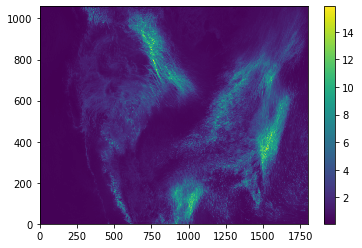

In [107]:
from scipy.ndimage import gaussian_filter, maximum_filter
plt.pcolormesh(gaussian_filter(all_data["href"]["MAXUVV"]['20210708'], 1))
plt.colorbar()

(600.0, 1000.0)

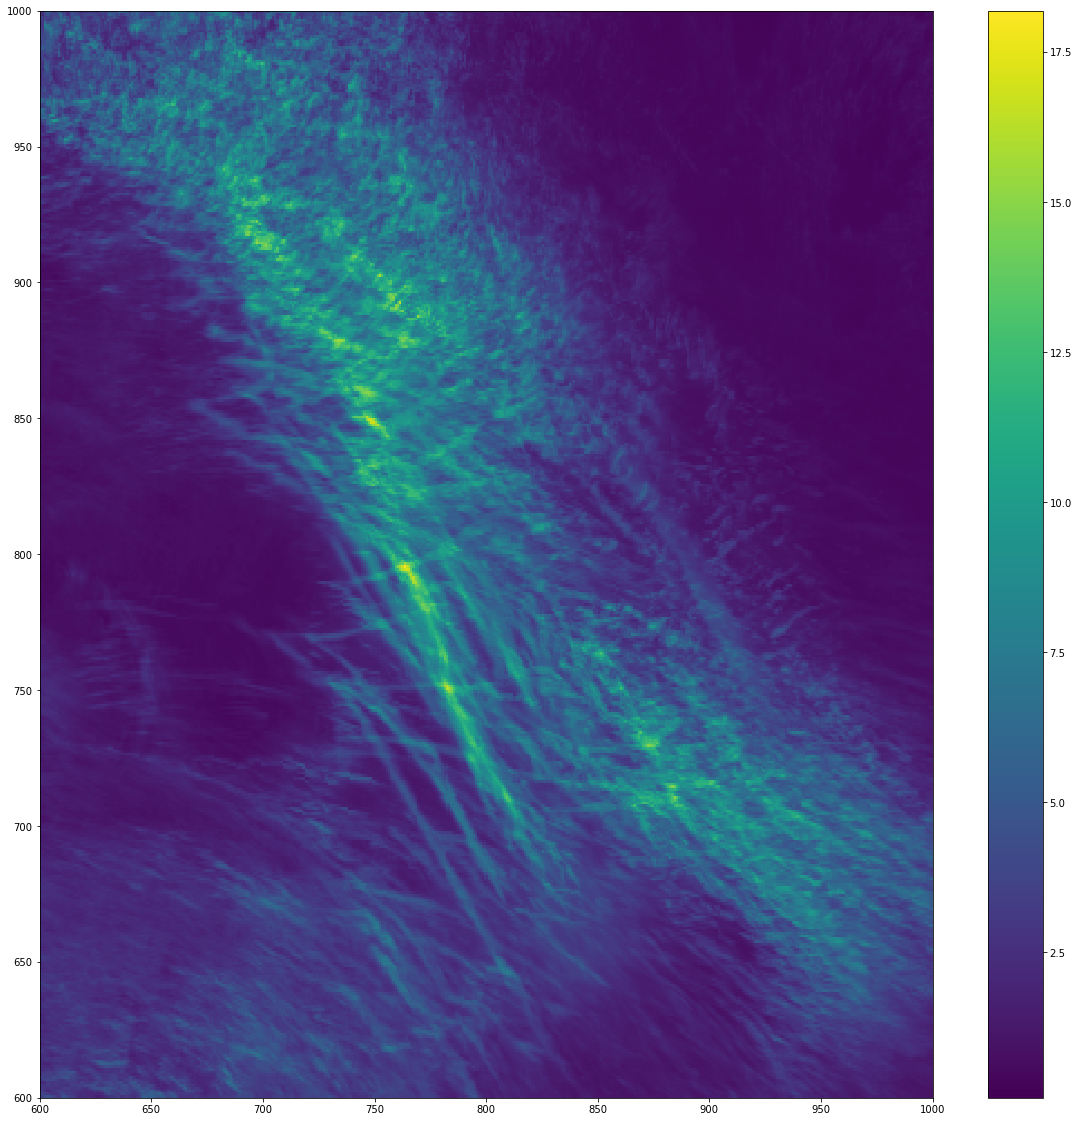

In [103]:
plt.figure(figsize=(20, 20))

plt.pcolormesh(all_data["href"]["MAXUVV"]['20210708'])
plt.colorbar()
plt.xlim(600, 1000)
plt.ylim(600, 1000)

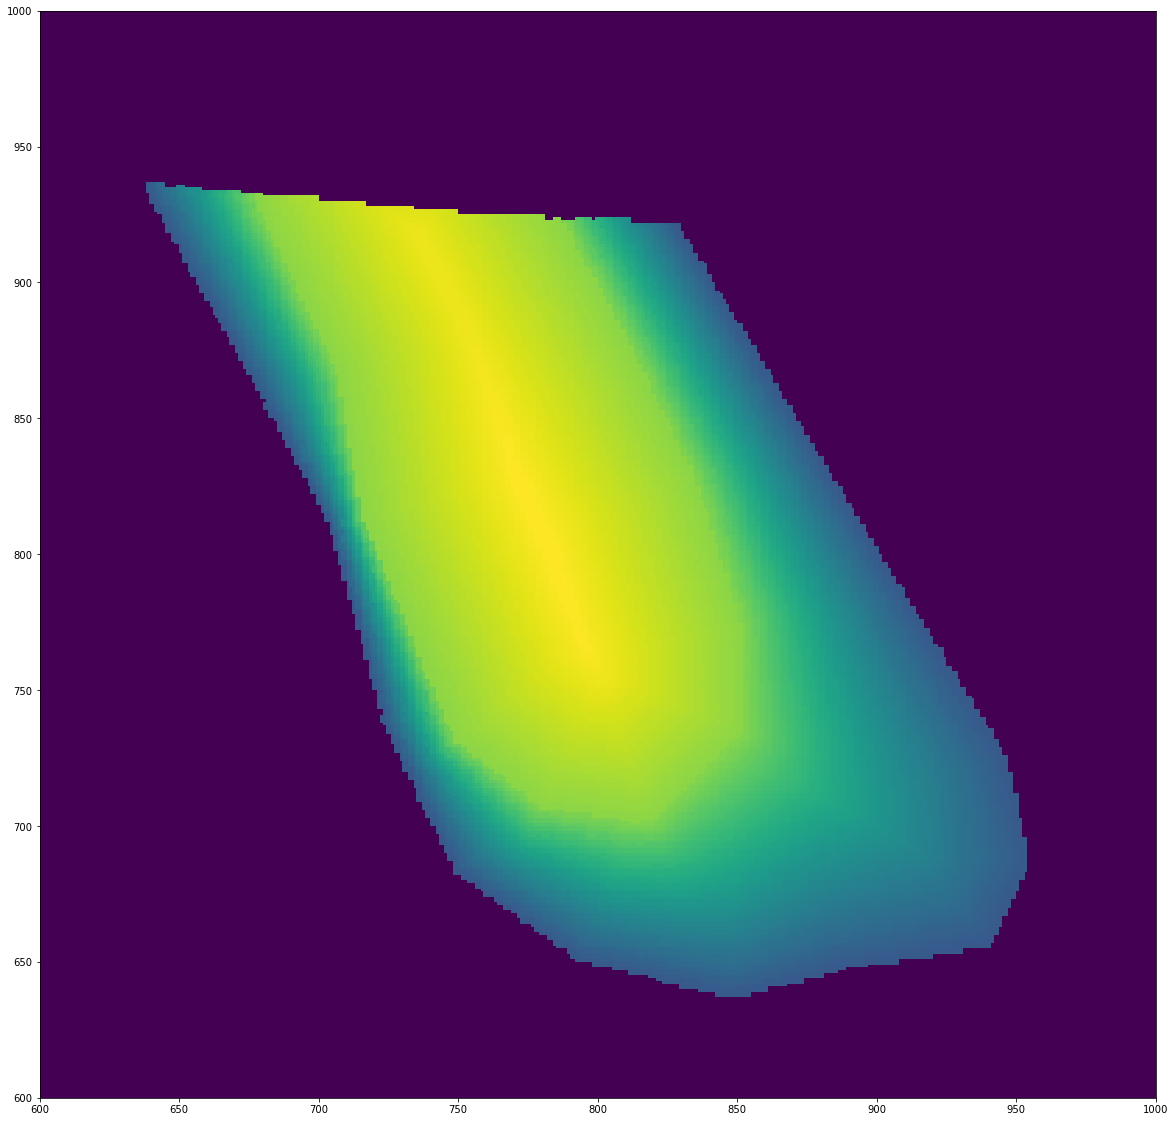

In [109]:
plt.figure(figsize=(20, 20))
plt.pcolormesh(maximum_filter(all_data["spc_1"][plot_date], 3))
plt.xlim(600, 1000)
plt.ylim(600, 1000)
plt.savefig("spc_prob_interp.png", dpi=200, bbox_inches="tight")

In [47]:
all_data["spc_nws"][plot_date].max()

KeyError: 'spc_nws'

In [25]:
all_data["burke_dl"][plot_date].ravel()[all_data["burke_dl"][plot_date].ravel() > 0].min()

0.0016